In [ ]:
import os
import pandas as pd
import numpy as np
from matplotlib.pylab import plt

# Read in Data

In [ ]:
from sklearn.model_selection import train_test_split

df_train = pd.read_csv('train_reduced.csv')
df_test = pd.read_csv('test_reduced.csv')

# Separate the feature columns (x) from the target column (y) in both DataFrames
X_train = df_train.drop('target', axis=1)
X_train = X_train.drop('ID', axis=1)
y_train = df_train['target']
#further split training data into train and validation:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,
                                                      test_size = 0.15,
                                                      random_state = 42)

X_test = df_test.drop('target', axis=1)
X_test = X_test.drop('ID', axis=1)
y_test = df_test['target']

print(X_train.columns)
print('Training data counts: ', X_train.shape)
print('Proportion of good and bad accounts in training data: \n', y_train.value_counts())
print('Validation data counts: ', X_valid.shape)
print('Proportion of good and bad accounts in validation data: \n', y_valid.value_counts())
print('Testing data counts: ', X_test.shape)
print('Proportion of good and bad accounts in testing data: \n', y_test.value_counts())

Index(['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'FLAG_WORK_PHONE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'EMPLOYED', 'LONG_TERM_UNEMPLOYED',
       'MARRIAGE_STATUS', 'EDUCATION', 'WAY_OF_LIVING', 'age_bins',
       'RATIO_EMPLOYED', 'Age_Children_Interaction', 'debt_to_income_ratio',
       'stable_employment', 'occupation_type_frequency',
       'occupation_mean_income', 'income_percentile_by_housing'],
      dtype='object')
Training data counts:  (24786, 19)
Proportion of good and bad accounts in training data: 
 1    16788
0     7998
Name: target, dtype: int64
Validation data counts:  (4374, 19)
Proportion of good and bad accounts in validation data: 
 1    2955
0    1419
Name: target, dtype: int64
Testing data counts:  (7291, 19)
Proportion of good and bad accounts in testing data: 
 1    4938
0    2353
Name: target, dtype: int64


1 refer to good and 0 refer to bad accounts. Bank incur a lot of losses when they accept bad accounts who accumulate bad debts and default. Hence, it is very crucial for our model to be able to be precise.

# Modelling

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc

# Function to evaluate the model and print metrics
def evaluate_model(model, X_train, y_train, X_valid, y_valid):
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = model.predict(X_valid)

    # Print accuracy
    print('Accuracy on validation set: {:.8f}'.format(accuracy_score(y_valid, y_pred)))

    # Print confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    print('True Neg:', tn, '\t' ,'False Pos:', fp)
    print('False Neg:', fn, '\t', 'True Pos:', tp)

    # Print precision and recall
    print('Precision on validation set: {:.8f}'.format(precision_score(y_valid, y_pred)))
    print('Recall on validation set: {:.8f}'.format(recall_score(y_valid, y_pred)))
    print('F1-Score on validation set: {:.8f}'.format(f1_score(y_valid, y_pred)))


    # Plot ROC Curve
    try:
        class_prob = model.predict_proba(X_valid)
        preds = class_prob[:, 1]
        fpr, tpr, threshold = roc_curve(y_valid, preds)
        roc_auc = auc(fpr, tpr)
        plt.figure()
        plt.plot(fpr, tpr, label='Model (area = %0.5f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc="lower right")
        plt.show()
    except AttributeError:
        print("Model does not have predict_proba method. ROC curve not plotted.")


## Logistic Regression

Accuracy on validation set: 0.67558299
True Neg: 0 	 False Pos: 1419
False Neg: 0 	 True Pos: 2955
Precision on validation set: 0.67558299
Recall on validation set: 1.00000000
F1-Score on validation set: 0.80638559


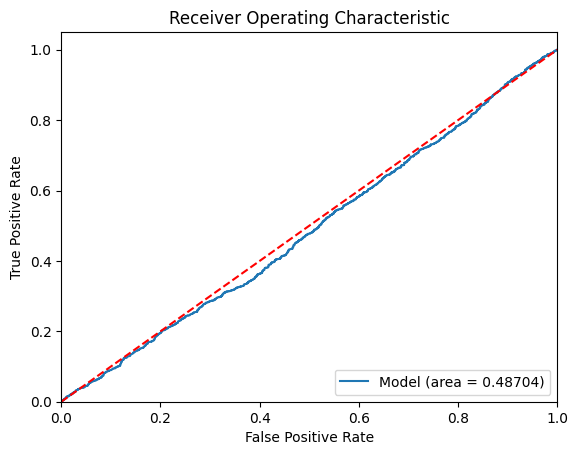

In [ ]:
from sklearn.linear_model import LogisticRegression

logReg = LogisticRegression()
evaluate_model(logReg, X_train, y_train, X_valid, y_valid)

### Weighted Logistic Regression

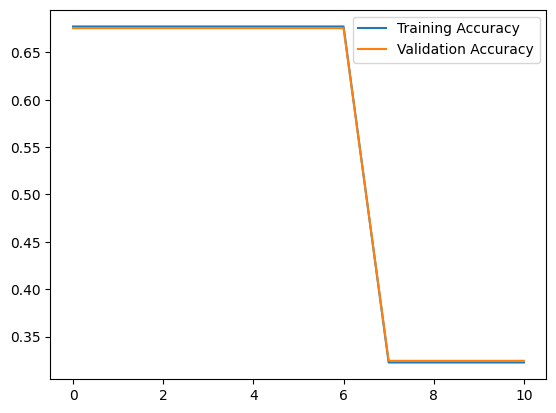

In [ ]:
logwt_trainaccuracy = np.zeros(shape=(11))
logwt_testaccuracy = np.zeros(shape=(11))

for weight in range(0, 11):
  wt = 0.1*weight
  wts = {0:wt, 1:1-wt}
  logwt = LogisticRegression(class_weight = wts)
  logwt.fit(X_train,y_train)
  logwt_trainaccuracy[weight]= logwt.score(X_train, y_train)
  logwt_testaccuracy[weight]= logwt.score(X_valid, y_valid)

depths = range(0, 11)

# Plot and label the training and validation loss values
plt.plot(depths, logwt_trainaccuracy, label='Training Accuracy')
plt.plot(depths, logwt_testaccuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

Tried weighted logistic regression but it predicts the class with higher weights. (ie. sharp drop after 6 => class weights {0: 0.6, 1: 0.4} which causes the model to predict all as 0 and we have about 1/3 33% of 0 classes)

### Feature Selection Logistic Regression

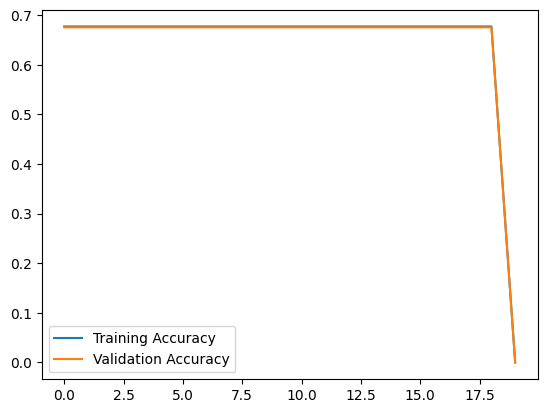

In [ ]:
from sklearn.feature_selection import RFE

train_acc = np.zeros(shape=(20))
valid_acc = np.zeros(shape=(20))


for i in range(1, 20):
    model = LogisticRegression()
    rfe = RFE(model, n_features_to_select=i)
    rfe.fit(X_train,y_train)
    train_acc[i - 1]= rfe.score(X_train, y_train)
    valid_acc[i - 1]= rfe.score(X_valid, y_valid)

depths = range(20)

# Plot and label the training and validation loss values
plt.plot(depths, train_acc, label='Training Accuracy')
plt.plot(depths, valid_acc, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

1
Accuracy on validation set: 0.67558299
True Neg: 0 	 False Pos: 1419
False Neg: 0 	 True Pos: 2955
Precision on validation set: 0.67558299
Recall on validation set: 1.00000000
F1-Score on validation set: 0.80638559


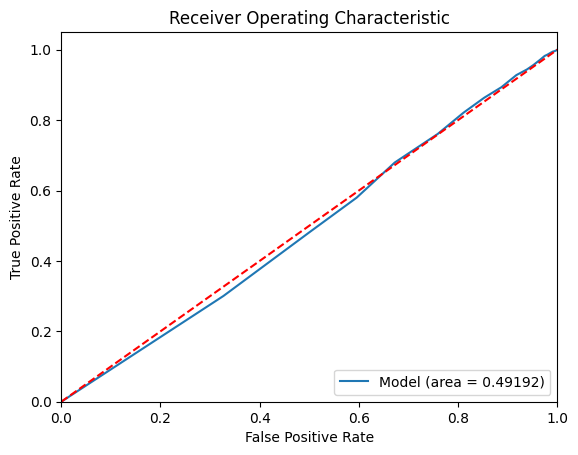

Index(['occupation_type_frequency'], dtype='object')


In [ ]:
d = valid_acc.argmax(axis=0) + 1
print(d)
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=d)
evaluate_model(rfe, X_train, y_train, X_valid, y_valid)

print(X_train.columns[rfe.support_])


## Decision Tree

Accuracy on validation set: 0.69455876
True Neg: 761 	 False Pos: 658
False Neg: 678 	 True Pos: 2277
Precision on validation set: 0.77580920
Recall on validation set: 0.77055838
F1-Score on validation set: 0.77317487


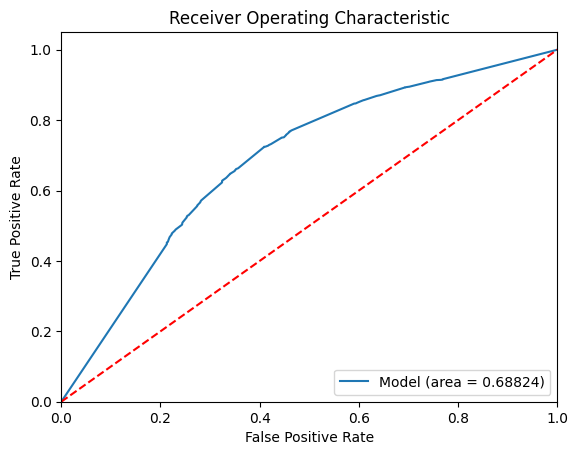

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier()
evaluate_model(tree, X_train, y_train, X_valid, y_valid)

### Max-Depth Decision Tree

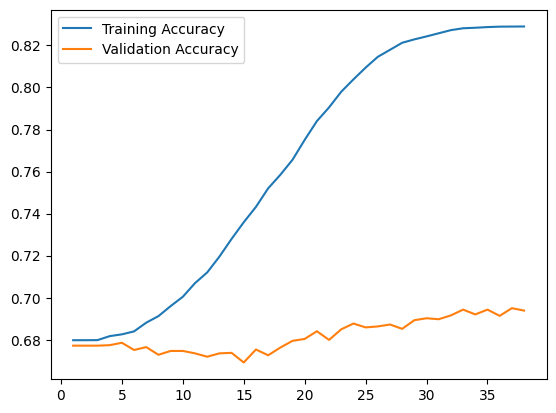

In [ ]:
tree_trainaccuracy = np.zeros(shape=(tree.tree_.max_depth))
tree_validaccuracy = np.zeros(shape=(tree.tree_.max_depth))
for max_d in range(1,tree.tree_.max_depth+1):
  tree2 = DecisionTreeClassifier(max_depth=max_d, random_state=42)
  tree2.fit(X_train,y_train)
  tree_trainaccuracy[max_d - 1]= tree2.score(X_train, y_train)
  tree_validaccuracy[max_d - 1]= tree2.score(X_valid, y_valid)

depths = range(1, tree.tree_.max_depth+1)

# Plot and label the training and validation loss values
plt.plot(depths, tree_trainaccuracy, label='Training Accuracy')
plt.plot(depths, tree_validaccuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

37
Accuracy on validation set: 0.69341564
True Neg: 757 	 False Pos: 662
False Neg: 679 	 True Pos: 2276
Precision on validation set: 0.77467665
Recall on validation set: 0.77021997
F1-Score on validation set: 0.77244188


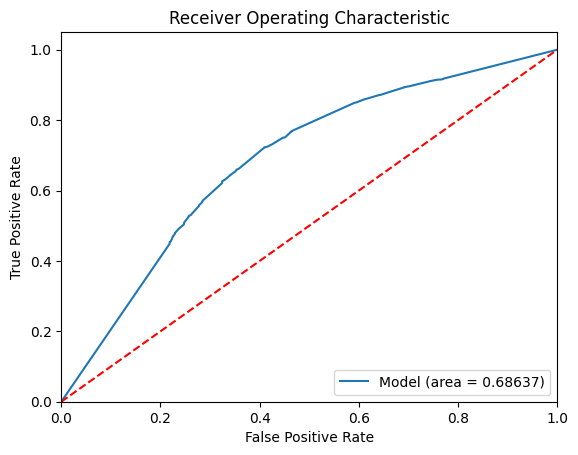

In [ ]:
# max_depth = sqrt(d)
d = tree_validaccuracy.argmax(axis=0) + 1
print(d)
tree_depth = DecisionTreeClassifier(max_depth=d)
evaluate_model(tree_depth, X_train, y_train, X_valid, y_valid)

Validation accuracy peaks at 34.

### Feature Selection Decision Tree

Index(['RATIO_EMPLOYED', 'Age_Children_Interaction',
       'occupation_type_frequency', 'occupation_mean_income',
       'income_percentile_by_housing'],
      dtype='object')
Accuracy on validation set: 0.62402707
True Neg: 1735 	 False Pos: 1220
False Neg: 1002 	 True Pos: 1953
Precision on validation set: 0.61550583
Recall on validation set: 0.66091371
F1-Score on validation set: 0.63740209


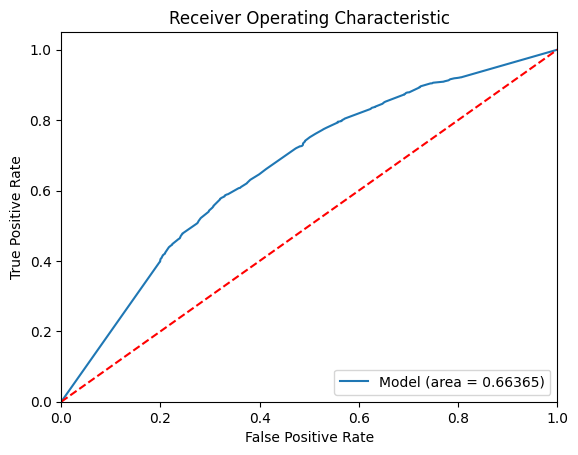

In [ ]:
from sklearn.feature_selection import SelectFromModel

sel = SelectFromModel(DecisionTreeClassifier())
sel.fit(X_train, y_train)
selected_feat= X_train.columns[(sel.get_support())]
print(selected_feat)

newX_train = X_train[selected_feat]
newX_valid = X_valid[selected_feat]

dt_feat = DecisionTreeClassifier()
evaluate_model(dt_feat, newX_train, y_train, newX_valid, y_valid)

Not much improvement with feature selection.

## Random Forest

Accuracy on validation set: 0.70850480
True Neg: 610 	 False Pos: 809
False Neg: 466 	 True Pos: 2489
Precision on validation set: 0.75469982
Recall on validation set: 0.84230118
F1-Score on validation set: 0.79609787


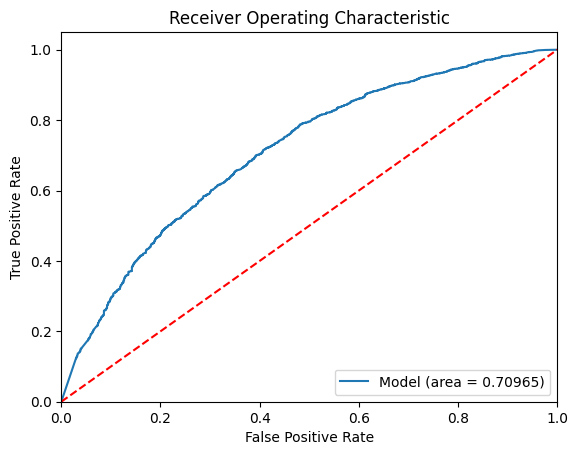

In [ ]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()
evaluate_model(forest, X_train, y_train, X_valid, y_valid)

### Max-Depth Random Forest

In [ ]:
forest_trainaccuracy = np.zeros(shape=(100))
forest_validaccuracy = np.zeros(shape=(100))
for max_d in range(1,100):
  rf = RandomForestClassifier(max_depth=max_d, random_state=42)
  rf.fit(X_train,y_train)
  forest_trainaccuracy[max_d - 1]= rf.score(X_train, y_train)
  forest_validaccuracy[max_d - 1]= rf.score(X_valid, y_valid)

depths = range(0, 100)

# Plot and label the training and validation loss values
plt.plot(depths, forest_trainaccuracy, label='Training Accuracy')
plt.plot(depths, forest_validaccuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

22
Accuracy on validation set: 0.64297800
True Neg: 1702 	 False Pos: 1253
False Neg: 857 	 True Pos: 2098
Precision on validation set: 0.62608177
Recall on validation set: 0.70998308
F1-Score on validation set: 0.66539803


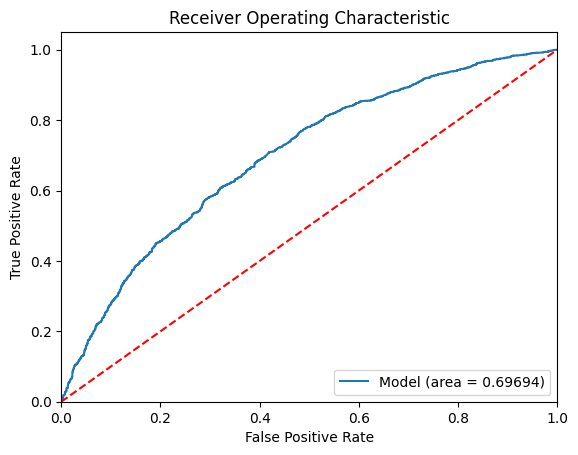

In [ ]:
# max_depth = sqrt(d)
d = forest_validaccuracy.argmax(axis=0) + 1
print(d)
rf_depth = RandomForestClassifier(max_depth=d)
evaluate_model(rf_depth, X_train, y_train, X_valid, y_valid)

### Random Forest Grid Search CV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}

In [ ]:
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,
                          cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)
print(grid_search.best_estimator_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


[CV] END bootstrap=True, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   4.2s
[CV] END bootstrap=True, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   4.2s
[CV] END bootstrap=True, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=100; total time=   4.2s
[CV] END bootstrap=True, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   8.7s
[CV] END bootstrap=True, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   8.7s
[CV] END bootstrap=True, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=200; total time=   8.9s
[CV] END bootstrap=True, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=  13.8s
[CV] END bootstrap=True, max_features=2, min_samples_leaf=3, min_samples_split=8, n_estimators=300; total time=  14.1s
[CV] END bootstrap=True, max_features=2, min_sam

Accuracy on validation set: 0.70324646
True Neg: 366 	 False Pos: 1053
False Neg: 245 	 True Pos: 2710
Precision on validation set: 0.72017008
Recall on validation set: 0.91708968
F1-Score on validation set: 0.80678773


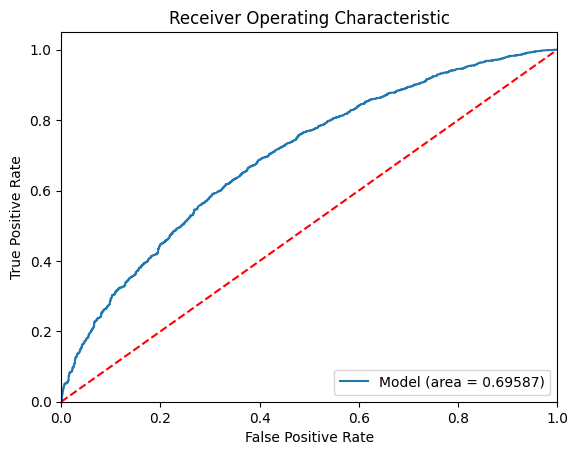

In [ ]:
rf_cvgrid = RandomForestClassifier(max_features=3, min_samples_leaf=3, min_samples_split=8,
                       n_estimators=200)
evaluate_model(rf_cvgrid, X_train, y_train, X_valid, y_valid)

### Random Forest Randomized Search CV

In [ ]:
from numpy.random import randint

rs_space={'max_depth':list(np.arange(10, 100, step=10)) + [None],
              'n_estimators':np.arange(10, 500, step=50),
              'max_features':np.arange(1,7, step=1),
              'criterion':['gini','entropy'],
              'min_samples_leaf':np.arange(1,4,step=1),
              'min_samples_split':np.arange(2, 10, step=2)
          }

random_search = RandomizedSearchCV(RandomForestClassifier(),
                                   rs_space)

In [ ]:
random_search.fit(X_train, y_train)
print(random_search.best_estimator_)

RandomForestClassifier(max_depth=30, max_features=4, min_samples_split=6,
                       n_estimators=310)


Accuracy on validation set: 0.71033379
True Neg: 574 	 False Pos: 845
False Neg: 422 	 True Pos: 2533
Precision on validation set: 0.74985198
Recall on validation set: 0.85719120
F1-Score on validation set: 0.79993684


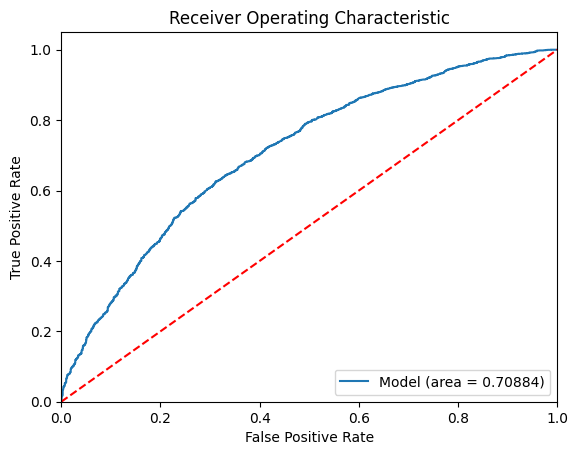

In [ ]:
rf_rscv = RandomForestClassifier(max_depth=30, max_features=4, min_samples_split=6,
                       n_estimators=310)
evaluate_model(rf_rscv, X_train, y_train, X_valid, y_valid)

## KNN

Accuracy on validation set: 0.61962775
True Neg: 1485 	 False Pos: 1470
False Neg: 778 	 True Pos: 2177
Precision on validation set: 0.59692898
Recall on validation set: 0.73671743
F1-Score on validation set: 0.65949712


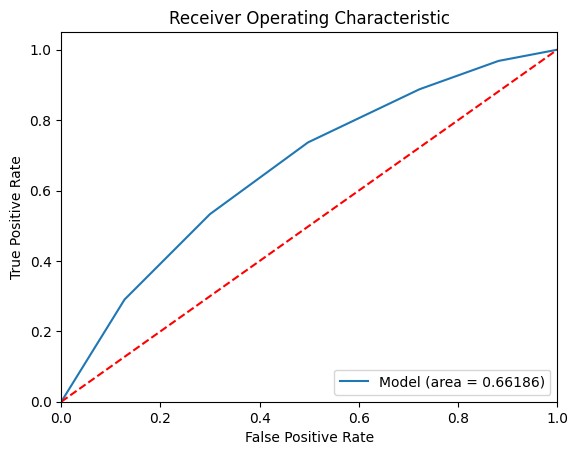

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
evaluate_model(knn_model, X_train, y_train, X_valid, y_valid)

### KNN: k values

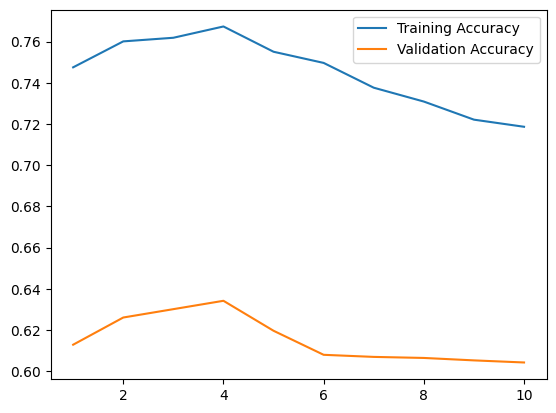

In [ ]:
kn_trainaccuracy = np.zeros(10)
kn_validaccuracy = np.zeros(10)
for k in range(1,11):
  kn = KNeighborsClassifier(n_neighbors=k)
  kn.fit(X_train,y_train)
  kn_trainaccuracy[k-1]= kn.score(X_train, y_train)
  kn_validaccuracy[k-1]= kn.score(X_valid, y_valid)

depths = range(1, 11)

# Plot and label the training and validation loss values
plt.plot(depths, kn_trainaccuracy, label='Training Accuracy')
plt.plot(depths, kn_validaccuracy, label='Validation Accuracy')
plt.legend(loc='best')
plt.show()

3
Accuracy on validation set: 0.63011844
True Neg: 1471 	 False Pos: 1484
False Neg: 702 	 True Pos: 2253
Precision on validation set: 0.60289002
Recall on validation set: 0.76243655
F1-Score on validation set: 0.67334130


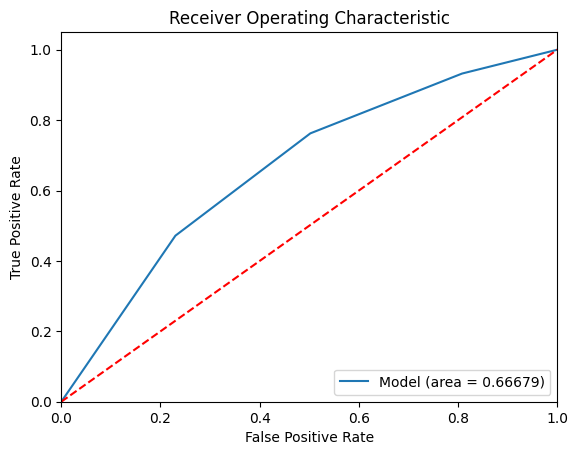

In [ ]:
k = kn_validaccuracy.argmax(axis=0)
print(k)
knn_k = KNeighborsClassifier(n_neighbors=k)
evaluate_model(knn_k, X_train, y_train, X_valid, y_valid)

### KNN: feature selection

In [ ]:
from mlxtend.evaluate import PredefinedHoldoutSplit
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

knn = KNeighborsClassifier(n_neighbors=4)

sfs1 = SFS(knn,
           k_features=3,
           forward=True,
           floating=False,
           verbose=2,
           scoring='accuracy')

sfs1 = sfs1.fit(X_train, y_train)



[2023-12-01 06:46:41] Features: 1/3 -- score: 0.6409045158160217
[2023-12-01 06:47:38] Features: 2/3 -- score: 0.6590424485020823
[2023-12-01 06:48:24] Features: 3/3 -- score: 0.6611570240237137

Selected features: (12, 14, 18)
Accuracy on validation set: 0.60812183
True Neg: 1772 	 False Pos: 1183
False Neg: 1133 	 True Pos: 1822
Precision on validation set: 0.60632280
Recall on validation set: 0.61658206
F1-Score on validation set: 0.61140940


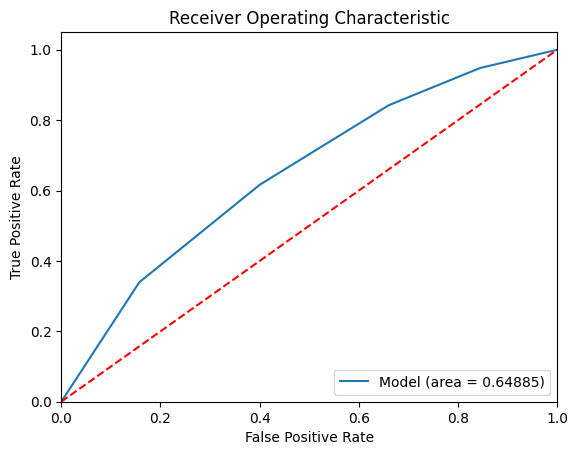

In [ ]:
print('Selected features:', sfs1.k_feature_idx_)
X_train_sfs = sfs1.transform(X_train)
X_valid_sfs = sfs1.transform(X_valid)
evaluate_model(knn, X_train_sfs, y_train, X_valid_sfs, y_valid)


## PCA/LDA/QDA/PLS

### PCA

In [ ]:
from sklearn.decomposition import PCA

pca = PCA()
pca_X_train = pca.fit_transform(X_train)
pca_X_test = pca.transform(X_valid)
pca_explained_variance = pca.explained_variance_ratio_

print(pca_explained_variance)

[9.85789626e-01 1.42091304e-02 1.23344433e-06 3.63034170e-09
 2.20866894e-09 1.25013779e-09 8.79980833e-10 4.84356582e-10
 4.52875198e-10 3.69099722e-10 3.29380796e-10 3.01305320e-10
 2.32598288e-10 1.98858574e-10 1.36091533e-10 1.07857181e-10
 7.88946949e-12 1.77753581e-17 2.16002190e-39]


First component explains about 98% of the variance, second component about 1.4%

In [ ]:
model_pca = PCA(n_components=2)
model_pca_X_train = model_pca.fit_transform(X_train)
model_pca_X_valid = model_pca.transform(X_valid)

Accuracy on validation set: 0.50118443
True Neg: 1126 	 False Pos: 1829
False Neg: 1119 	 True Pos: 1836
Precision on validation set: 0.50095498
Recall on validation set: 0.62131980
F1-Score on validation set: 0.55468278


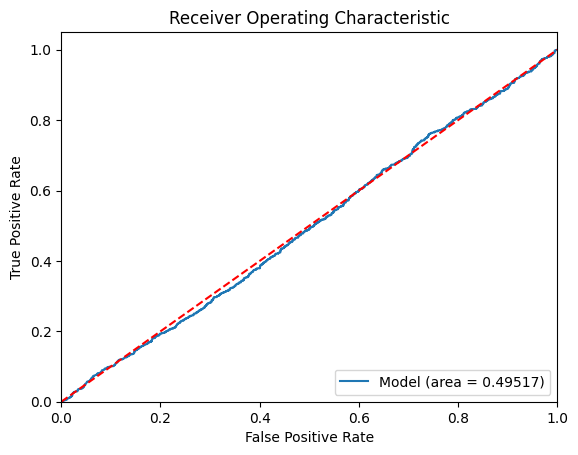

In [ ]:
pca_logReg = LogisticRegression()
evaluate_model(pca_logReg, model_pca_X_train, y_train, model_pca_X_valid, y_valid)

Accuracy on validation set: 0.52994924
True Neg: 1297 	 False Pos: 1658
False Neg: 1120 	 True Pos: 1835
Precision on validation set: 0.52533639
Recall on validation set: 0.62098139
F1-Score on validation set: 0.56916873


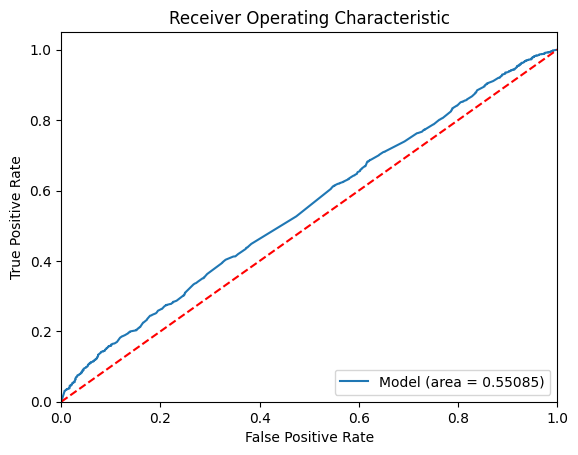

In [ ]:
pca_tree = RandomForestClassifier()
evaluate_model(pca_tree, model_pca_X_train, y_train, model_pca_X_valid, y_valid)

Performs more poorly

Accuracy on validation set: 0.61895093
True Neg: 1705 	 False Pos: 1250
False Neg: 1002 	 True Pos: 1953
Precision on validation set: 0.60974087
Recall on validation set: 0.66091371
F1-Score on validation set: 0.63429685


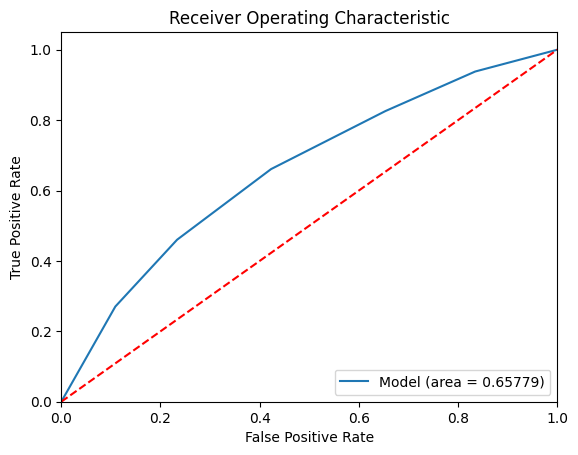

In [ ]:
pca_knn = KNeighborsClassifier()
evaluate_model(pca_knn, model_pca_X_train, y_train, model_pca_X_valid, y_valid)

### LDA

Accuracy on validation set: 0.52774958
True Neg: 1457 	 False Pos: 1498
False Neg: 1293 	 True Pos: 1662
Precision on validation set: 0.52594937
Recall on validation set: 0.56243655
F1-Score on validation set: 0.54358136


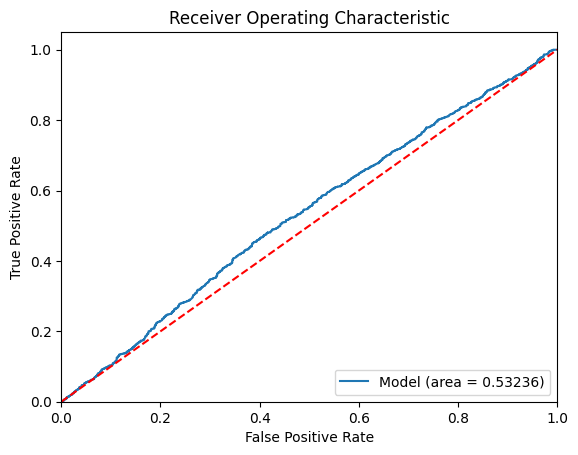

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()
evaluate_model(lda, X_train, y_train, X_valid, y_valid)

### QDA

/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:926: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Accuracy on validation set: 0.51218274
True Neg: 614 	 False Pos: 2341
False Neg: 542 	 True Pos: 2413
Precision on validation set: 0.50757257
Recall on validation set: 0.81658206
F1-Score on validation set: 0.62602153


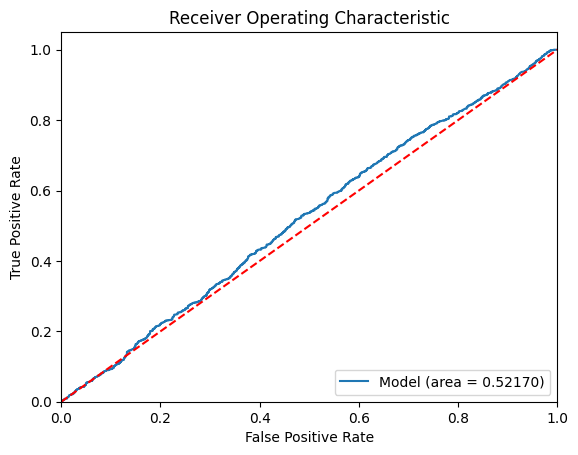

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
evaluate_model(qda, X_train, y_train, X_valid, y_valid)

### PLS

In [ ]:
from sklearn.cross_decomposition import PLSRegression
pls_binary = PLSRegression(n_components=2)
pls_binary.fit(X_train, y_train)

pls_ypred_raw = pls_binary.predict(X_valid)[:,0]
pls_ypred = (pls_binary.predict(X_valid)[:,0] > 0.5).astype('uint8')

print('Precision of PLS-DA classifier on test set: {:.2f}'.format(accuracy_score(y_valid, pls_ypred)))
print('Precision of PLS-DA classifier on test set: {:.2f}'.format(precision_score(y_valid, pls_ypred)))
print('Recall of PLS-DA classifier on test set: {:.2f}'.format(recall_score(y_valid, pls_ypred)))

Precision of PLS-DA classifier on test set: 0.53
Precision of PLS-DA classifier on test set: 0.52
Recall of PLS-DA classifier on test set: 0.56


## NaiveBayes

Accuracy on validation set: 0.51607445
True Neg: 1310 	 False Pos: 1645
False Neg: 1215 	 True Pos: 1740
Precision on validation set: 0.51403250
Recall on validation set: 0.58883249
F1-Score on validation set: 0.54889590


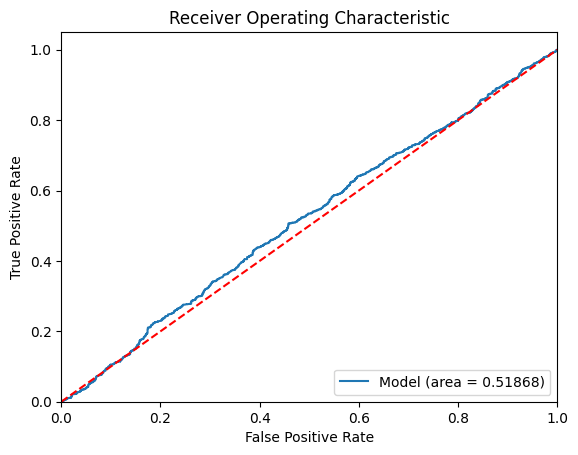

In [ ]:
from sklearn.naive_bayes import GaussianNB
nb_model = GaussianNB()
evaluate_model(nb_model, X_train, y_train, X_valid, y_valid)

## Boosting

### XGBOOST

Accuracy on validation set: 0.68952904
True Neg: 281 	 False Pos: 1138
False Neg: 220 	 True Pos: 2735
Precision on validation set: 0.70617093
Recall on validation set: 0.92554992
F1-Score on validation set: 0.80111306


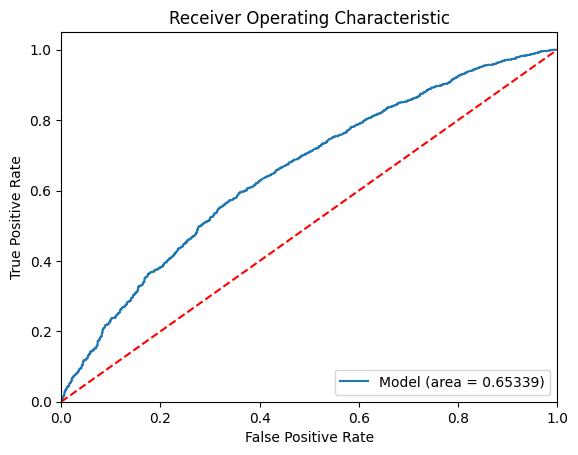

In [ ]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(objective="multi:softmax", num_class=2)
evaluate_model(xgb_model, X_train, y_train, X_valid, y_valid)

### CatBoost

0:	learn: 0.6852370	total: 157ms	remaining: 1m 18s
1:	learn: 0.6777127	total: 203ms	remaining: 50.5s
2:	learn: 0.6725361	total: 208ms	remaining: 34.5s
3:	learn: 0.6673406	total: 271ms	remaining: 33.7s
4:	learn: 0.6624078	total: 322ms	remaining: 31.9s
5:	learn: 0.6578546	total: 417ms	remaining: 34.3s
6:	learn: 0.6531636	total: 609ms	remaining: 42.9s
7:	learn: 0.6491753	total: 689ms	remaining: 42.4s
8:	learn: 0.6462835	total: 699ms	remaining: 38.1s
9:	learn: 0.6429209	total: 750ms	remaining: 36.7s
10:	learn: 0.6401163	total: 804ms	remaining: 35.7s
11:	learn: 0.6372509	total: 861ms	remaining: 35s
12:	learn: 0.6352753	total: 873ms	remaining: 32.7s
13:	learn: 0.6331767	total: 942ms	remaining: 32.7s
14:	learn: 0.6306774	total: 1.13s	remaining: 36.5s
15:	learn: 0.6286291	total: 1.31s	remaining: 39.8s
16:	learn: 0.6275124	total: 1.35s	remaining: 38.3s
17:	learn: 0.6252010	total: 1.54s	remaining: 41.3s
18:	learn: 0.6233290	total: 1.66s	remaining: 42.1s
19:	learn: 0.6217812	total: 1.77s	remainin

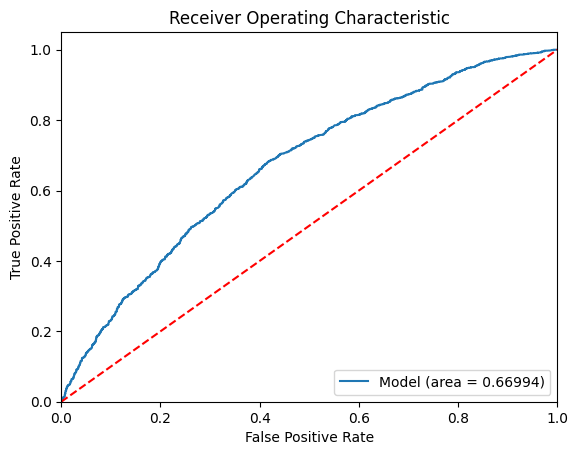

In [ ]:
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=10, loss_function='Logloss')
evaluate_model(catboost_model, X_train, y_train, X_valid, y_valid)

### LGB

[LightGBM] [Info] Number of positive: 16788, number of negative: 7998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.096248 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 660
[LightGBM] [Info] Number of data points in the train set: 24786, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677318 -> initscore=0.741473
[LightGBM] [Info] Start training from score 0.741473
Accuracy on validation set: 0.69204390
True Neg: 230 	 False Pos: 1189
False Neg: 158 	 True Pos: 2797
Precision on validation set: 0.70170597
Recall on validation set: 0.94653130
F1-Score on validation set: 0.80593574


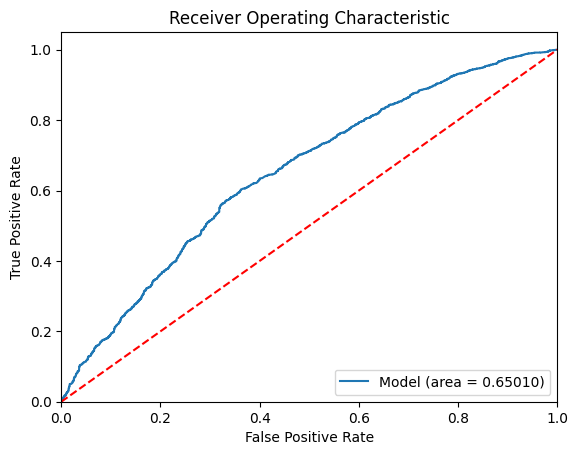

In [ ]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=500)
evaluate_model(lgb_model, X_train, y_train, X_valid, y_valid)

## Ensemble Classifier

0:	learn: 0.6852370	total: 187ms	remaining: 1m 33s
1:	learn: 0.6777127	total: 275ms	remaining: 1m 8s
2:	learn: 0.6725361	total: 279ms	remaining: 46.3s
3:	learn: 0.6673406	total: 323ms	remaining: 40.1s
4:	learn: 0.6624078	total: 361ms	remaining: 35.7s
5:	learn: 0.6578546	total: 421ms	remaining: 34.7s
6:	learn: 0.6531636	total: 531ms	remaining: 37.4s
7:	learn: 0.6491753	total: 696ms	remaining: 42.8s
8:	learn: 0.6462835	total: 726ms	remaining: 39.6s
9:	learn: 0.6429209	total: 846ms	remaining: 41.5s
10:	learn: 0.6401163	total: 944ms	remaining: 41.9s
11:	learn: 0.6372509	total: 992ms	remaining: 40.4s
12:	learn: 0.6352753	total: 1s	remaining: 37.7s
13:	learn: 0.6331767	total: 1.05s	remaining: 36.3s
14:	learn: 0.6306774	total: 1.09s	remaining: 35.2s
15:	learn: 0.6286291	total: 1.14s	remaining: 34.4s
16:	learn: 0.6275124	total: 1.14s	remaining: 32.5s
17:	learn: 0.6252010	total: 1.24s	remaining: 33.2s
18:	learn: 0.6233290	total: 1.41s	remaining: 35.8s
19:	learn: 0.6217812	total: 1.5s	remaining:

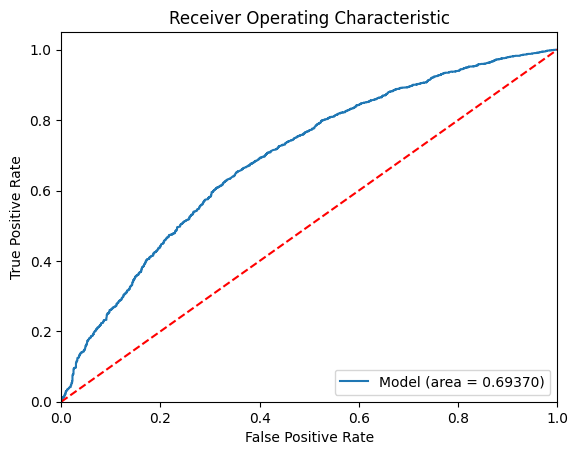

In [ ]:
# Ensemble with Default RF
from sklearn.ensemble import VotingClassifier

xgb_model = XGBClassifier(learning_rate=0.05, n_estimators=500)
catboost_model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=10, loss_function='Logloss')
rf_model = RandomForestClassifier()
lgb_model = lgb.LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=500)

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('catboost', catboost_model),
    ('rf', rf_model),
    ('lgb', lgb_model)
], voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

evaluate_model(ensemble_model, X_train, y_train, X_valid, y_valid)

0:	learn: 0.6852370	total: 52.7ms	remaining: 26.3s
1:	learn: 0.6777127	total: 153ms	remaining: 38s
2:	learn: 0.6725361	total: 193ms	remaining: 32s
3:	learn: 0.6673406	total: 316ms	remaining: 39.2s
4:	learn: 0.6624078	total: 390ms	remaining: 38.6s
5:	learn: 0.6578546	total: 437ms	remaining: 36s
6:	learn: 0.6531636	total: 480ms	remaining: 33.8s
7:	learn: 0.6491753	total: 536ms	remaining: 33s
8:	learn: 0.6462835	total: 575ms	remaining: 31.4s
9:	learn: 0.6429209	total: 690ms	remaining: 33.8s
10:	learn: 0.6401163	total: 782ms	remaining: 34.8s
11:	learn: 0.6372509	total: 873ms	remaining: 35.5s
12:	learn: 0.6352753	total: 902ms	remaining: 33.8s
13:	learn: 0.6331767	total: 1.02s	remaining: 35.4s
14:	learn: 0.6306774	total: 1.08s	remaining: 34.8s
15:	learn: 0.6286291	total: 1.13s	remaining: 34.1s
16:	learn: 0.6275124	total: 1.14s	remaining: 32.3s
17:	learn: 0.6252010	total: 1.19s	remaining: 31.8s
18:	learn: 0.6233290	total: 1.27s	remaining: 32.2s
19:	learn: 0.6217812	total: 1.39s	remaining: 33.

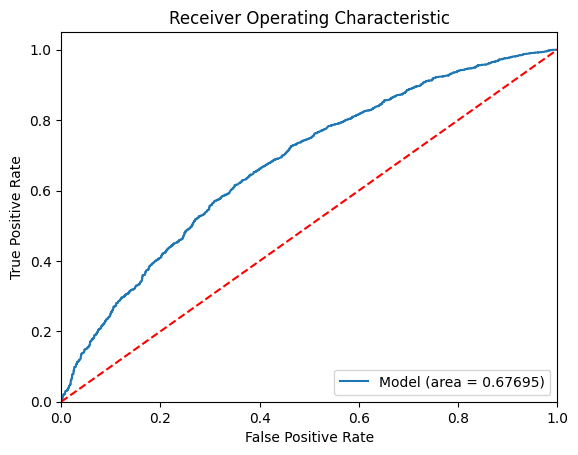

In [ ]:
# Ensemble with Grid Search CV RF

xgb_model = XGBClassifier(learning_rate=0.05, n_estimators=500)
catboost_model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=10, loss_function='Logloss')
rf_model = RandomForestClassifier(max_features=3, n_estimators=200, min_samples_leaf=3, min_samples_split=8)
lgb_model = lgb.LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=500)

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('catboost', catboost_model),
    ('rf', rf_model),
    ('lgb', lgb_model)
], voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

evaluate_model(ensemble_model, X_train, y_train, X_valid, y_valid)

0:	learn: 0.6852370	total: 39.2ms	remaining: 19.5s
1:	learn: 0.6777127	total: 122ms	remaining: 30.3s
2:	learn: 0.6725361	total: 125ms	remaining: 20.7s
3:	learn: 0.6673406	total: 157ms	remaining: 19.5s
4:	learn: 0.6624078	total: 187ms	remaining: 18.5s
5:	learn: 0.6578546	total: 216ms	remaining: 17.8s
6:	learn: 0.6531636	total: 244ms	remaining: 17.2s
7:	learn: 0.6491753	total: 276ms	remaining: 17s
8:	learn: 0.6462835	total: 284ms	remaining: 15.5s
9:	learn: 0.6429209	total: 316ms	remaining: 15.5s
10:	learn: 0.6401163	total: 345ms	remaining: 15.3s
11:	learn: 0.6372509	total: 374ms	remaining: 15.2s
12:	learn: 0.6352753	total: 386ms	remaining: 14.4s
13:	learn: 0.6331767	total: 414ms	remaining: 14.4s
14:	learn: 0.6306774	total: 448ms	remaining: 14.5s
15:	learn: 0.6286291	total: 478ms	remaining: 14.5s
16:	learn: 0.6275124	total: 482ms	remaining: 13.7s
17:	learn: 0.6252010	total: 512ms	remaining: 13.7s
18:	learn: 0.6233290	total: 539ms	remaining: 13.6s
19:	learn: 0.6217812	total: 579ms	remainin

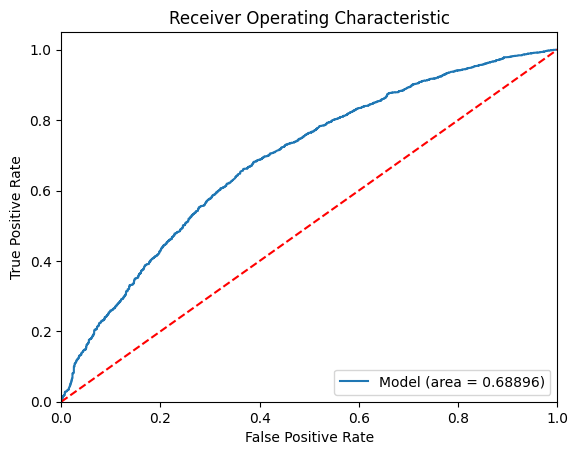

In [ ]:
# Ensemble with Randomnised Search CV RF

xgb_model = XGBClassifier(learning_rate=0.05, n_estimators=500)
catboost_model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=10, loss_function='Logloss')
rf_model = RandomForestClassifier(max_depth=30, max_features=4, min_samples_split=6,
                       n_estimators=310)
lgb_model = lgb.LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=500)

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('catboost', catboost_model),
    ('rf', rf_model),
    ('lgb', lgb_model)
], voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

evaluate_model(ensemble_model, X_train, y_train, X_valid, y_valid)

Accuracy on validation set: 0.71353452
True Neg: 543 	 False Pos: 876
False Neg: 377 	 True Pos: 2578
Precision on validation set: 0.74638101
Recall on validation set: 0.87241963
F1-Score on validation set: 0.80449368


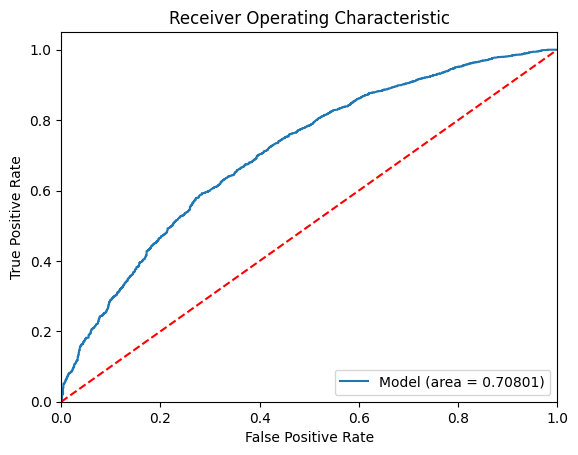

In [ ]:
# Ensemble with RFs

rfscv = RandomForestClassifier(max_depth=30, max_features=4, min_samples_split=6,
                       n_estimators=310)
rfcv = RandomForestClassifier(max_features=3, n_estimators=200, min_samples_leaf=3, min_samples_split=8)
rf_model = RandomForestClassifier()

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('rfcv', rfcv),
    ('rfscv', rfscv)
], voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

evaluate_model(ensemble_model, X_train, y_train, X_valid, y_valid)

Accuracy on validation set: 0.70004572
True Neg: 377 	 False Pos: 1042
False Neg: 270 	 True Pos: 2685
Precision on validation set: 0.72041857
Recall on validation set: 0.90862944
F1-Score on validation set: 0.80365160


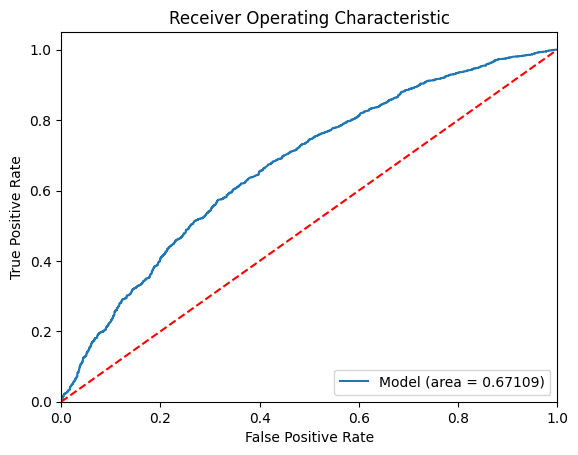

In [ ]:
xgb_model_1 = XGBClassifier(learning_rate=0.1, n_estimators=1000)
xgb_model_2 = XGBClassifier(learning_rate=0.05, n_estimators=2000)
xgb_model_3 = XGBClassifier(learning_rate=0.01, n_estimators=3000)

# Create an ensemble model using VotingClassifier
ensemble_xgb = VotingClassifier(estimators=[
    ('xgb_1', xgb_model_1),
    ('xgb_2', xgb_model_2),
    ('xgb_3', xgb_model_3)
], voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

evaluate_model(ensemble_xgb, X_train, y_train, X_valid, y_valid)

0:	learn: 0.6797350	total: 68.2ms	remaining: 1m 8s
1:	learn: 0.6690725	total: 92.4ms	remaining: 46.1s
2:	learn: 0.6604423	total: 109ms	remaining: 36.2s
3:	learn: 0.6532066	total: 126ms	remaining: 31.3s
4:	learn: 0.6475027	total: 143ms	remaining: 28.4s
5:	learn: 0.6428402	total: 165ms	remaining: 27.4s
6:	learn: 0.6390674	total: 188ms	remaining: 26.7s
7:	learn: 0.6359404	total: 206ms	remaining: 25.5s
8:	learn: 0.6332353	total: 225ms	remaining: 24.8s
9:	learn: 0.6312150	total: 244ms	remaining: 24.1s
10:	learn: 0.6297660	total: 255ms	remaining: 22.9s
11:	learn: 0.6282525	total: 279ms	remaining: 22.9s
12:	learn: 0.6269970	total: 303ms	remaining: 23s
13:	learn: 0.6258787	total: 323ms	remaining: 22.8s
14:	learn: 0.6249531	total: 347ms	remaining: 22.8s
15:	learn: 0.6241152	total: 365ms	remaining: 22.5s
16:	learn: 0.6234715	total: 381ms	remaining: 22s
17:	learn: 0.6230892	total: 391ms	remaining: 21.3s
18:	learn: 0.6225492	total: 407ms	remaining: 21s
19:	learn: 0.6218332	total: 423ms	remaining: 

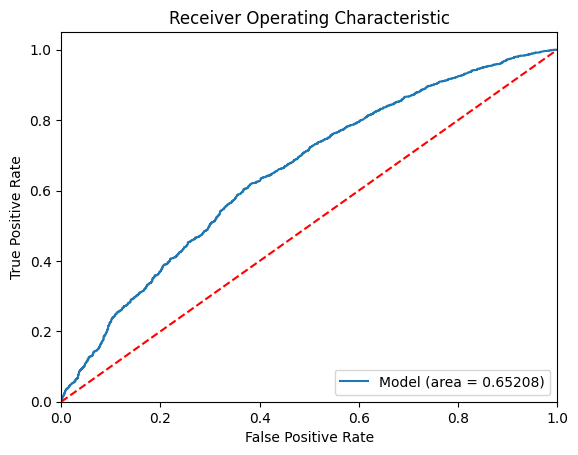

In [ ]:
catboost_model_1 = CatBoostClassifier(learning_rate=0.1, n_estimators=1000)
catboost_model_2 = CatBoostClassifier(learning_rate=0.05, n_estimators=2000)
catboost_model_3 = CatBoostClassifier(learning_rate=0.01, n_estimators=3000)

# Create an ensemble model using VotingClassifier
ensemble_cb = VotingClassifier(estimators=[
    ('cb_1', catboost_model_1),
    ('cb_2', catboost_model_2),
    ('cb_3', catboost_model_3)
], voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

evaluate_model(ensemble_cb, X_train, y_train, X_valid, y_valid)

[LightGBM] [Info] Number of positive: 16788, number of negative: 7998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003488 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 660
[LightGBM] [Info] Number of data points in the train set: 24786, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.677318 -> initscore=0.741473
[LightGBM] [Info] Start training from score 0.741473
[LightGBM] [Info] Number of positive: 16788, number of negative: 7998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002467 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 660
[LightGBM] [Info] Number of data points in the train set: 24786, number of used features: 19
[LightGBM] [Info] [binar

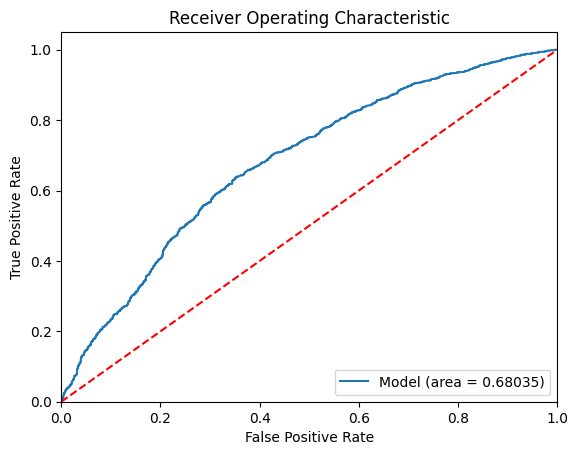

In [ ]:
lgb_model_1 = LGBMClassifier(learning_rate=0.1, n_estimators=1000)
lgb_model_2 = LGBMClassifier(learning_rate=0.05, n_estimators=2000)
lgb_model_3 = LGBMClassifier(learning_rate=0.01, n_estimators=3000)

# Create an ensemble model using VotingClassifier
ensemble_lgb = VotingClassifier(estimators=[
    ('lgb_1', lgb_model_1),
    ('lgb_2', lgb_model_2),
    ('lgb_3', lgb_model_3)
], voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

evaluate_model(ensemble_lgb, X_train, y_train, X_valid, y_valid)

## Final Models

In [ ]:
#Combine Training and Validation to be used to train the final models

X_frames = [X_train, X_valid]
y_frames = [y_train, y_valid]
X_final = pd.concat(X_frames)
y_final = pd.concat(y_frames)

Accuracy on validation set: 0.70772185
True Neg: 514 	 False Pos: 1839
False Neg: 292 	 True Pos: 4646
Precision on validation set: 0.71642251
Recall on validation set: 0.94086675
F1-Score on validation set: 0.81344656


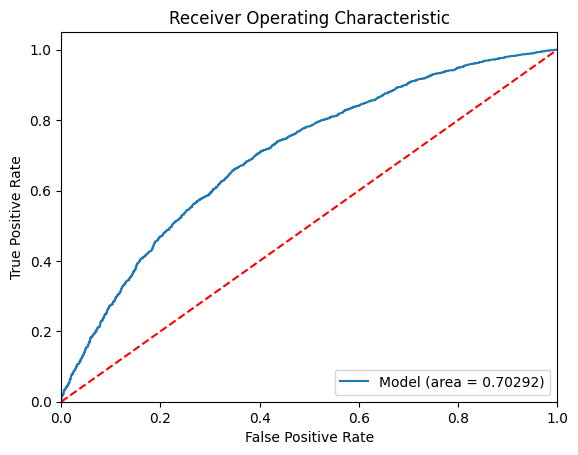

In [ ]:
# Model with Best Accuracy
# Ensemble with RFs

rfscv = RandomForestClassifier(max_depth=30, max_features=4, min_samples_split=6,
                       n_estimators=310)
rfcv = RandomForestClassifier(max_features=3, n_estimators=200, min_samples_leaf=3, min_samples_split=8)
rf_model = RandomForestClassifier()

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('rf', rf_model),
    ('rfcv', rfcv),
    ('rfscv', rfscv)
], voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

evaluate_model(ensemble_model, X_final, y_final, X_test, y_test)

Accuracy on validation set: 0.57344672
True Neg: 1200 	 False Pos: 1153
False Neg: 1957 	 True Pos: 2981
Precision on validation set: 0.72109337
Recall on validation set: 0.60368570
F1-Score on validation set: 0.65718695


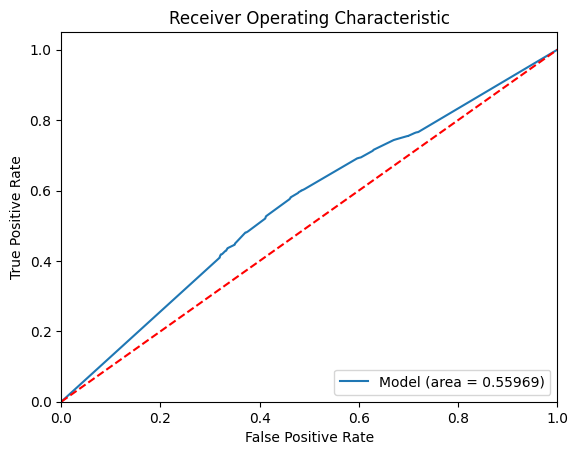

In [ ]:
# Model with Best Precision
tree_depth = DecisionTreeClassifier(max_depth=37)
evaluate_model(tree_depth, X_final, y_final, X_test, y_test)

0:	learn: 0.6854443	total: 58.2ms	remaining: 29.1s
1:	learn: 0.6783361	total: 97.3ms	remaining: 24.2s
2:	learn: 0.6731716	total: 102ms	remaining: 16.9s
3:	learn: 0.6674227	total: 142ms	remaining: 17.6s
4:	learn: 0.6630447	total: 150ms	remaining: 14.8s
5:	learn: 0.6581032	total: 182ms	remaining: 15s
6:	learn: 0.6541838	total: 215ms	remaining: 15.1s
7:	learn: 0.6505858	total: 245ms	remaining: 15.1s
8:	learn: 0.6473011	total: 280ms	remaining: 15.3s
9:	learn: 0.6434424	total: 320ms	remaining: 15.7s
10:	learn: 0.6404815	total: 353ms	remaining: 15.7s
11:	learn: 0.6375304	total: 386ms	remaining: 15.7s
12:	learn: 0.6343555	total: 421ms	remaining: 15.8s
13:	learn: 0.6321029	total: 452ms	remaining: 15.7s
14:	learn: 0.6299307	total: 486ms	remaining: 15.7s
15:	learn: 0.6286348	total: 492ms	remaining: 14.9s
16:	learn: 0.6275268	total: 498ms	remaining: 14.1s
17:	learn: 0.6256413	total: 529ms	remaining: 14.2s
18:	learn: 0.6245425	total: 541ms	remaining: 13.7s
19:	learn: 0.6236181	total: 548ms	remaini

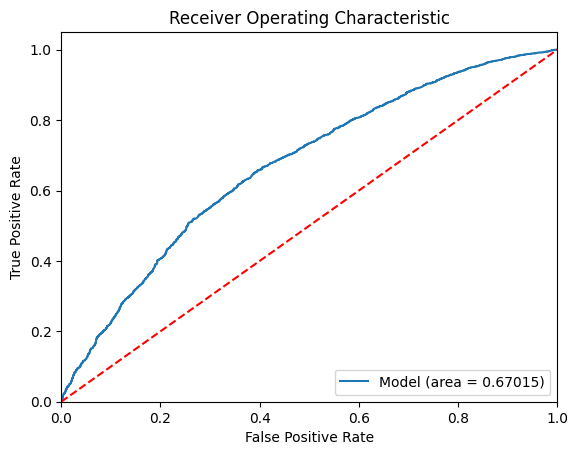

In [ ]:
# Model with Best Recall
xgb_model = XGBClassifier(learning_rate=0.05, n_estimators=500)
catboost_model = CatBoostClassifier(iterations=500, learning_rate=0.05, depth=10, loss_function='Logloss')
rf_model = RandomForestClassifier(max_features=3, n_estimators=200, min_samples_leaf=3, min_samples_split=8)
lgb_model = lgb.LGBMClassifier(num_leaves=31, learning_rate=0.05, n_estimators=500)

# Create an ensemble model using VotingClassifier
ensemble_model = VotingClassifier(estimators=[
    ('xgb', xgb_model),
    ('catboost', catboost_model),
    ('rf', rf_model),
    ('lgb', lgb_model)
], voting='soft')  # 'soft' for soft voting, 'hard' for hard voting

evaluate_model(ensemble_model,X_final, y_final, X_test, y_test)